In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [5]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [6]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [7]:



# Create a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # When using fancy indexing on a memmap, a copy is made only for this batch.
        return self.memmap_array[batch_idx]

# --- Data Loading Without Loading Entire Dataset Into RAM ---

# Load the dataset with memory mapping so that the full array isn’t loaded into RAM immediately.
save_path = "E:/dataset_1/preprocessed_fear.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path, mmap_mode='r')  # memmap; data remains on disk until accessed
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Use StratifiedShuffleSplit to get train/test indices without forcing a full copy.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(x_data, y_data))

# Sorting indices can help get more contiguous slices.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

# Instead of slicing x_data (which would copy a 12GB block into memory),
# create Sequences that load data in batches.
batch_size = 32
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is small so we load it normally.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test: {y_test.shape}")

# --- Training the Model ---
# Now call your train_model function as before—but pass the Sequence objects instead of full numpy arrays.
# For example:
#
# spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))
# train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test)
#
# Keras model.predict (and model.fit, if needed) supports Sequence objects, so your existing
# build_model() and train_model() functions remain unchanged.


📂 Loading precomputed dataset from E:/dataset_1/preprocessed_fear.npz...
✅ Loaded dataset: 20000 samples.
📊 Train/Test Split:
  x_train_seq: 500 batches (batch_size=32), y_train: (16000,)
  x_test_seq: 125 batches (batch_size=32), y_test: (4000,)


In [8]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(



Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1983s 4s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 499s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5133 - loss: 0.6930
Epoch 1: val_accuracy improved from -inf to 0.84525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.5133 - loss: 0.6930 - val_accuracy: 0.8453 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5978 - loss: 0.6897
Epoch 2: val_accuracy did not improve from 0.84525
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5979 - loss: 0.6897 - val_accuracy: 0.5000 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 3/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7126 - loss: 0.6627
Epoch 3: val_accuracy did not improve from 0.84525
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7127 - loss: 0.6626 - val_accuracy: 0.5000 - val_loss: 1.0355 - learning_rate: 1.0000e-04
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7946 - loss: 0.5474
Epoch 4: val_accuracy did not improve from 0.84525
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7946 - loss: 0.5473 - val_accuracy: 0.5000 - val_loss: 1.9263 - learning_rate: 1.0000

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8578 - loss: 0.3268 - val_accuracy: 0.8620 - val_loss: 0.3109 - learning_rate: 1.0000e-04
Epoch 8/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8601 - loss: 0.3228
Epoch 8: val_accuracy did not improve from 0.86200
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8601 - loss: 0.3228 - val_accuracy: 0.8590 - val_loss: 0.3006 - learning_rate: 1.0000e-04
Epoch 9/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8626 - loss: 0.3107
Epoch 9: val_accuracy did not improve from 0.86200
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8626 - loss: 0.3107 - val_accuracy: 0.8595 - val_loss: 0.3111 - learning_rate: 1.0000e-04
Epoch 10/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8609 - loss: 0.3192
Epoch 10: val_accuracy improved from 0.86200 to 0.86750, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8609 - loss: 0.3192 - val_accuracy: 0.8675 - val_loss: 0.2875 - learning_rate: 1.0000e-04
Epoch 11/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8604 - loss: 0.3142
Epoch 11: val_accuracy improved from 0.86750 to 0.87150, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8605 - loss: 0.3142 - val_accuracy: 0.8715 - val_loss: 0.2859 - learning_rate: 1.0000e-04
Epoch 12/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8682 - loss: 0.3065
Epoch 12: val_accuracy did not improve from 0.87150
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8682 - loss: 0.3065 - val_accuracy: 0.8545 - val_loss: 0.3194 - learning_rate: 1.0000e-04
Epoch 13/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8733 - loss: 0.3024
Epoch 13: val_accuracy did not improve from 0.87150
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8733 - loss: 0.3023 - val_accuracy: 0.8610 - val_loss: 0.3137 - learning_rate: 1.0000e-04
Epoch 14/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8720 - loss: 0.2951
Epoch 14: val_accuracy improved from 0.87150 to 0.87725, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8720 - loss: 0.2951 - val_accuracy: 0.8773 - val_loss: 0.2740 - learning_rate: 1.0000e-04
Epoch 15/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - loss: 0.2908
Epoch 15: val_accuracy improved from 0.87725 to 0.88175, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8750 - loss: 0.2908 - val_accuracy: 0.8817 - val_loss: 0.2656 - learning_rate: 1.0000e-04
Epoch 16/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8738 - loss: 0.2923
Epoch 16: val_accuracy improved from 0.88175 to 0.88875, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8738 - loss: 0.2923 - val_accuracy: 0.8888 - val_loss: 0.2597 - learning_rate: 1.0000e-04
Epoch 17/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8798 - loss: 0.2749
Epoch 17: val_accuracy did not improve from 0.88875
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8798 - loss: 0.2749 - val_accuracy: 0.8875 - val_loss: 0.2561 - learning_rate: 1.0000e-04
Epoch 18/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8855 - loss: 0.2805
Epoch 18: val_accuracy improved from 0.88875 to 0.89100, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8855 - loss: 0.2805 - val_accuracy: 0.8910 - val_loss: 0.2514 - learning_rate: 1.0000e-04
Epoch 19/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8854 - loss: 0.2764
Epoch 19: val_accuracy did not improve from 0.89100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8854 - loss: 0.2764 - val_accuracy: 0.8763 - val_loss: 0.2865 - learning_rate: 1.0000e-04
Epoch 20/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8857 - loss: 0.2774
Epoch 20: val_accuracy improved from 0.89100 to 0.89600, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8857 - loss: 0.2774 - val_accuracy: 0.8960 - val_loss: 0.2456 - learning_rate: 1.0000e-04
Epoch 21/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8879 - loss: 0.2669
Epoch 21: val_accuracy improved from 0.89600 to 0.90650, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8879 - loss: 0.2669 - val_accuracy: 0.9065 - val_loss: 0.2330 - learning_rate: 1.0000e-04
Epoch 22/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8903 - loss: 0.2597
Epoch 22: val_accuracy did not improve from 0.90650
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8903 - loss: 0.2597 - val_accuracy: 0.8855 - val_loss: 0.2631 - learning_rate: 1.0000e-04
Epoch 23/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8952 - loss: 0.2538
Epoch 23: val_accuracy did not improve from 0.90650
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8952 - loss: 0.2538 - val_accuracy: 0.9060 - val_loss: 0.2322 - learning_rate: 1.0000e-04
Epoch 24/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8962 - loss: 0.2510
Epoch 24: val_accuracy did not improve from 0.90650
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8962 - loss: 0.2510 - val_accuracy: 0.8815 - val_loss: 0.2769 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8992 - loss: 0.2451 - val_accuracy: 0.9168 - val_loss: 0.2062 - learning_rate: 1.0000e-04
Epoch 27/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9093 - loss: 0.2349
Epoch 27: val_accuracy improved from 0.91675 to 0.91950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9093 - loss: 0.2349 - val_accuracy: 0.9195 - val_loss: 0.2048 - learning_rate: 1.0000e-04
Epoch 28/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9091 - loss: 0.2306
Epoch 28: val_accuracy improved from 0.91950 to 0.92150, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9091 - loss: 0.2306 - val_accuracy: 0.9215 - val_loss: 0.1975 - learning_rate: 1.0000e-04
Epoch 29/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9146 - loss: 0.2144
Epoch 29: val_accuracy improved from 0.92150 to 0.92375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9146 - loss: 0.2145 - val_accuracy: 0.9237 - val_loss: 0.1914 - learning_rate: 1.0000e-04
Epoch 30/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9088 - loss: 0.2306
Epoch 30: val_accuracy did not improve from 0.92375
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9088 - loss: 0.2306 - val_accuracy: 0.9068 - val_loss: 0.2193 - learning_rate: 1.0000e-04
Epoch 31/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9132 - loss: 0.2178
Epoch 31: val_accuracy did not improve from 0.92375
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9132 - loss: 0.2178 - val_accuracy: 0.9147 - val_loss: 0.2019 - learning_rate: 1.0000e-04
Epoch 32/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9128 - loss: 0.2218
Epoch 32: val_accuracy improved from 0.92375 to 0.93150, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9128 - loss: 0.2218 - val_accuracy: 0.9315 - val_loss: 0.1772 - learning_rate: 1.0000e-04
Epoch 33/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9172 - loss: 0.2085
Epoch 33: val_accuracy did not improve from 0.93150
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9172 - loss: 0.2085 - val_accuracy: 0.9305 - val_loss: 0.1827 - learning_rate: 1.0000e-04
Epoch 34/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9201 - loss: 0.2037
Epoch 34: val_accuracy did not improve from 0.93150
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9201 - loss: 0.2037 - val_accuracy: 0.9158 - val_loss: 0.2020 - learning_rate: 1.0000e-04
Epoch 35/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9208 - loss: 0.2008
Epoch 35: val_accuracy did not improve from 0.93150
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9208 - loss: 0.2008 - val_accuracy: 0.9280 - val_loss: 0.1781 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9246 - loss: 0.1931 - val_accuracy: 0.9415 - val_loss: 0.1570 - learning_rate: 1.0000e-04
Epoch 37/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9247 - loss: 0.1910
Epoch 37: val_accuracy did not improve from 0.94150
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9246 - loss: 0.1910 - val_accuracy: 0.9395 - val_loss: 0.1558 - learning_rate: 1.0000e-04
Epoch 38/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9255 - loss: 0.1934
Epoch 38: val_accuracy improved from 0.94150 to 0.94625, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9255 - loss: 0.1934 - val_accuracy: 0.9463 - val_loss: 0.1479 - learning_rate: 1.0000e-04
Epoch 39/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9287 - loss: 0.1884
Epoch 39: val_accuracy did not improve from 0.94625
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9287 - loss: 0.1884 - val_accuracy: 0.9362 - val_loss: 0.1634 - learning_rate: 1.0000e-04
Epoch 40/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9248 - loss: 0.1928
Epoch 40: val_accuracy did not improve from 0.94625
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9248 - loss: 0.1927 - val_accuracy: 0.9367 - val_loss: 0.1639 - learning_rate: 1.0000e-04
Epoch 41/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9230 - loss: 0.1917
Epoch 41: val_accuracy improved from 0.94625 to 0.94800, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9230 - loss: 0.1917 - val_accuracy: 0.9480 - val_loss: 0.1389 - learning_rate: 1.0000e-04
Epoch 42/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9279 - loss: 0.1859
Epoch 42: val_accuracy improved from 0.94800 to 0.95100, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9279 - loss: 0.1859 - val_accuracy: 0.9510 - val_loss: 0.1343 - learning_rate: 1.0000e-04
Epoch 43/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9299 - loss: 0.1823
Epoch 43: val_accuracy did not improve from 0.95100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9299 - loss: 0.1823 - val_accuracy: 0.9503 - val_loss: 0.1353 - learning_rate: 1.0000e-04
Epoch 44/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9351 - loss: 0.1738
Epoch 44: val_accuracy improved from 0.95100 to 0.95375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9351 - loss: 0.1738 - val_accuracy: 0.9538 - val_loss: 0.1289 - learning_rate: 1.0000e-04
Epoch 45/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9308 - loss: 0.1783
Epoch 45: val_accuracy did not improve from 0.95375
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9308 - loss: 0.1783 - val_accuracy: 0.9320 - val_loss: 0.1788 - learning_rate: 1.0000e-04
Epoch 46/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9348 - loss: 0.1806
Epoch 46: val_accuracy improved from 0.95375 to 0.95525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9348 - loss: 0.1805 - val_accuracy: 0.9553 - val_loss: 0.1235 - learning_rate: 1.0000e-04
Epoch 47/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9346 - loss: 0.1699
Epoch 47: val_accuracy did not improve from 0.95525
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9346 - loss: 0.1700 - val_accuracy: 0.9542 - val_loss: 0.1259 - learning_rate: 1.0000e-04
Epoch 48/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9313 - loss: 0.1757
Epoch 48: val_accuracy improved from 0.95525 to 0.95700, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9313 - loss: 0.1757 - val_accuracy: 0.9570 - val_loss: 0.1195 - learning_rate: 1.0000e-04
Epoch 49/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9375 - loss: 0.1727
Epoch 49: val_accuracy did not improve from 0.95700
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9375 - loss: 0.1727 - val_accuracy: 0.9557 - val_loss: 0.1254 - learning_rate: 1.0000e-04
Epoch 50/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9432 - loss: 0.1550
Epoch 50: val_accuracy did not improve from 0.95700
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9432 - loss: 0.1550 - val_accuracy: 0.9570 - val_loss: 0.1186 - learning_rate: 1.0000e-04
Epoch 51/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9380 - loss: 0.1593
Epoch 51: val_accuracy did not improve from 0.95700
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9380 - loss: 0.1593 - val_accuracy: 0.9570 - val_loss: 0.1267 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9421 - loss: 0.1562 - val_accuracy: 0.9582 - val_loss: 0.1144 - learning_rate: 1.0000e-04
Epoch 53/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9326 - loss: 0.1714
Epoch 53: val_accuracy did not improve from 0.95825
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9326 - loss: 0.1714 - val_accuracy: 0.9553 - val_loss: 0.1199 - learning_rate: 1.0000e-04
Epoch 54/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9381 - loss: 0.1642
Epoch 54: val_accuracy did not improve from 0.95825
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9381 - loss: 0.1642 - val_accuracy: 0.9503 - val_loss: 0.1463 - learning_rate: 1.0000e-04
Epoch 55/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9419 - loss: 0.1608
Epoch 55: val_accuracy did not improve from 0.95825
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9419 - loss: 0.1608 - val_accuracy: 0.9567 - val_loss: 0.1319 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9339 - loss: 0.1734 - val_accuracy: 0.9592 - val_loss: 0.1074 - learning_rate: 1.0000e-04
Epoch 57/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9431 - loss: 0.1527
Epoch 57: val_accuracy improved from 0.95925 to 0.96125, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9431 - loss: 0.1527 - val_accuracy: 0.9613 - val_loss: 0.1074 - learning_rate: 1.0000e-04
Epoch 58/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9430 - loss: 0.1488
Epoch 58: val_accuracy did not improve from 0.96125
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9430 - loss: 0.1489 - val_accuracy: 0.9427 - val_loss: 0.1450 - learning_rate: 1.0000e-04
Epoch 59/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9389 - loss: 0.1613
Epoch 59: val_accuracy improved from 0.96125 to 0.96300, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9389 - loss: 0.1613 - val_accuracy: 0.9630 - val_loss: 0.1055 - learning_rate: 1.0000e-04
Epoch 60/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9438 - loss: 0.1541
Epoch 60: val_accuracy did not improve from 0.96300
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9438 - loss: 0.1541 - val_accuracy: 0.9622 - val_loss: 0.1041 - learning_rate: 1.0000e-04
Epoch 61/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9392 - loss: 0.1641
Epoch 61: val_accuracy did not improve from 0.96300
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9392 - loss: 0.1641 - val_accuracy: 0.9628 - val_loss: 0.1185 - learning_rate: 1.0000e-04
Epoch 62/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9415 - loss: 0.1615
Epoch 62: val_accuracy did not improve from 0.96300
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9415 - loss: 0.1615 - val_accuracy: 0.9525 - val_loss: 0.1422 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9431 - loss: 0.1545 - val_accuracy: 0.9650 - val_loss: 0.1048 - learning_rate: 1.0000e-04
Epoch 64/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9398 - loss: 0.1672
Epoch 64: val_accuracy did not improve from 0.96500

Epoch 64: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9398 - loss: 0.1672 - val_accuracy: 0.9515 - val_loss: 0.1221 - learning_rate: 1.0000e-04
Epoch 65/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9434 - loss: 0.1533
Epoch 65: val_accuracy did not improve from 0.96500
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9434 - loss: 0.1533 - val_accuracy: 0.9617 - val_loss: 0.1049 - learning_rate: 5.0000e-05
Epoch 66/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9481 - loss: 0.1442
Epoch 66: val_accuracy did not improve from 0.96500
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9516 - loss: 0.1356 - val_accuracy: 0.9663 - val_loss: 0.0993 - learning_rate: 5.0000e-05
Epoch 69/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9459 - loss: 0.1398
Epoch 69: val_accuracy did not improve from 0.96625
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9459 - loss: 0.1398 - val_accuracy: 0.9663 - val_loss: 0.0977 - learning_rate: 5.0000e-05
Epoch 70/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9472 - loss: 0.1454
Epoch 70: val_accuracy improved from 0.96625 to 0.96750, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9473 - loss: 0.1453 - val_accuracy: 0.9675 - val_loss: 0.0997 - learning_rate: 5.0000e-05
Epoch 71/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9482 - loss: 0.1429
Epoch 71: val_accuracy did not improve from 0.96750
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9482 - loss: 0.1429 - val_accuracy: 0.9663 - val_loss: 0.1031 - learning_rate: 5.0000e-05
Epoch 72/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9534 - loss: 0.1306
Epoch 72: val_accuracy improved from 0.96750 to 0.96825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9533 - loss: 0.1306 - val_accuracy: 0.9682 - val_loss: 0.0972 - learning_rate: 5.0000e-05
Epoch 73/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9452 - loss: 0.1493
Epoch 73: val_accuracy did not improve from 0.96825
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9452 - loss: 0.1493 - val_accuracy: 0.9670 - val_loss: 0.0937 - learning_rate: 5.0000e-05
Epoch 74/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9490 - loss: 0.1403
Epoch 74: val_accuracy did not improve from 0.96825
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9490 - loss: 0.1403 - val_accuracy: 0.9620 - val_loss: 0.1023 - learning_rate: 5.0000e-05
Epoch 75/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9520 - loss: 0.1403
Epoch 75: val_accuracy did not improve from 0.96825
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9520 - loss: 0.1403 - val_accuracy: 0.9668 - val_loss: 0.0933 - learning_rate: 5

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9451 - loss: 0.1439 - val_accuracy: 0.9690 - val_loss: 0.0973 - learning_rate: 5.0000e-05
Epoch 78/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9485 - loss: 0.1325
Epoch 78: val_accuracy did not improve from 0.96900
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9485 - loss: 0.1325 - val_accuracy: 0.9657 - val_loss: 0.0940 - learning_rate: 5.0000e-05
Epoch 79/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9487 - loss: 0.1396
Epoch 79: val_accuracy did not improve from 0.96900
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9487 - loss: 0.1396 - val_accuracy: 0.9663 - val_loss: 0.0926 - learning_rate: 5.0000e-05
Epoch 80/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9493 - loss: 0.1393
Epoch 80: val_accuracy did not improve from 0.96900
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9493 - loss: 0.1394 - val_accuracy: 0.9670 - val_loss: 0.0909 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9488 - loss: 0.1357 - val_accuracy: 0.9710 - val_loss: 0.0921 - learning_rate: 5.0000e-05
Epoch 82/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9491 - loss: 0.1390
Epoch 82: val_accuracy improved from 0.97100 to 0.97175, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9491 - loss: 0.1390 - val_accuracy: 0.9718 - val_loss: 0.0941 - learning_rate: 5.0000e-05
Epoch 83/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9422 - loss: 0.1529
Epoch 83: val_accuracy did not improve from 0.97175
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9422 - loss: 0.1529 - val_accuracy: 0.9693 - val_loss: 0.0939 - learning_rate: 5.0000e-05
Epoch 84/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9480 - loss: 0.1335
Epoch 84: val_accuracy did not improve from 0.97175

Epoch 84: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9480 - loss: 0.1335 - val_accuracy: 0.9605 - val_loss: 0.1016 - learning_rate: 5.0000e-05
Epoch 85/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9488 - loss: 0.1422
Epoch 85: val_accuracy did not improve from 0.97175
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.948

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9545 - loss: 0.1321 - val_accuracy: 0.9722 - val_loss: 0.0861 - learning_rate: 2.5000e-05
Epoch 94/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9515 - loss: 0.1259
Epoch 94: val_accuracy improved from 0.97225 to 0.97250, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9515 - loss: 0.1258 - val_accuracy: 0.9725 - val_loss: 0.0865 - learning_rate: 2.5000e-05
Epoch 95/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9538 - loss: 0.1290
Epoch 95: val_accuracy did not improve from 0.97250
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9538 - loss: 0.1290 - val_accuracy: 0.9725 - val_loss: 0.0884 - learning_rate: 2.5000e-05
Epoch 96/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9524 - loss: 0.1307
Epoch 96: val_accuracy improved from 0.97250 to 0.97325, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9524 - loss: 0.1307 - val_accuracy: 0.9732 - val_loss: 0.0854 - learning_rate: 2.5000e-05
Epoch 97/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9541 - loss: 0.1256
Epoch 97: val_accuracy did not improve from 0.97325
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9541 - loss: 0.1256 - val_accuracy: 0.9645 - val_loss: 0.0956 - learning_rate: 2.5000e-05
Epoch 98/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9521 - loss: 0.1319
Epoch 98: val_accuracy did not improve from 0.97325
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9521 - loss: 0.1319 - val_accuracy: 0.9722 - val_loss: 0.0851 - learning_rate: 2.5000e-05
Epoch 99/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9538 - loss: 0.1280
Epoch 99: val_accuracy improved from 0.97325 to 0.97350, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9538 - loss: 0.1280 - val_accuracy: 0.9735 - val_loss: 0.0860 - learning_rate: 2.5000e-05
Epoch 100/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9490 - loss: 0.1383
Epoch 100: val_accuracy did not improve from 0.97350
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9490 - loss: 0.1383 - val_accuracy: 0.9732 - val_loss: 0.0845 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 100.
Training completed.
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


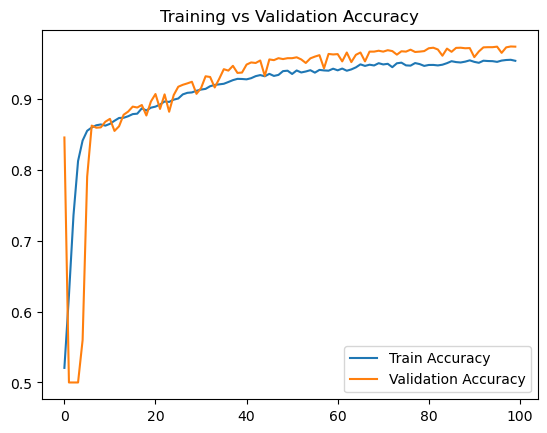

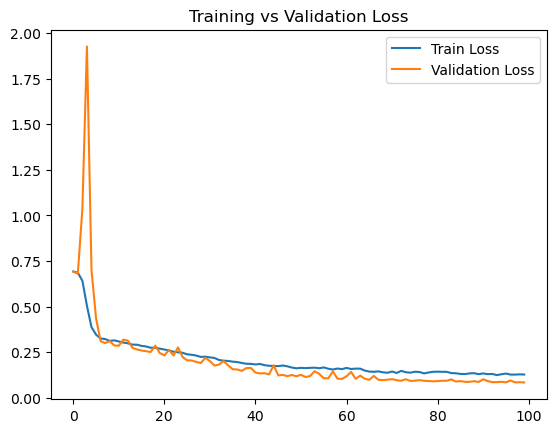

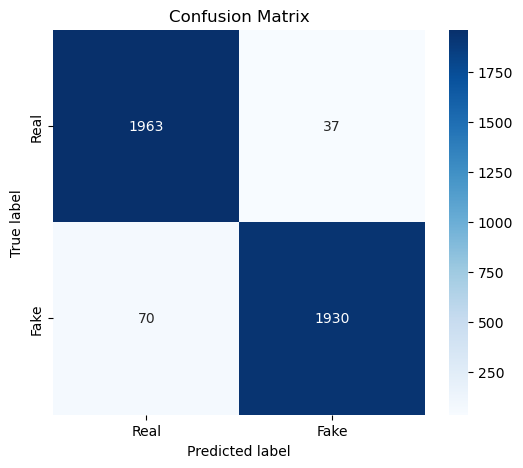

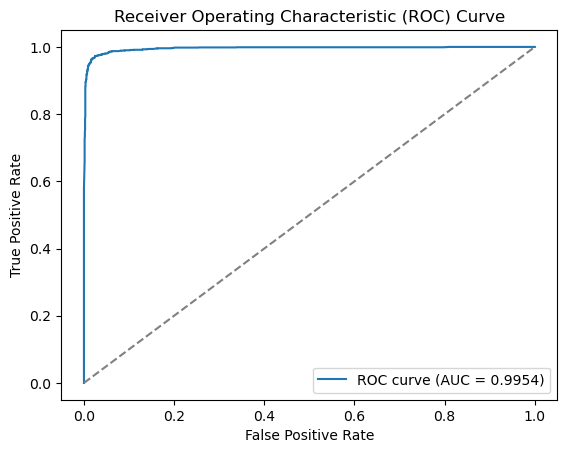

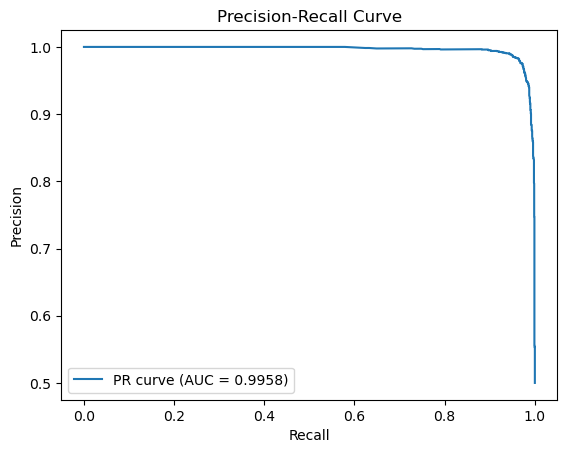

Accuracy Score: 0.9732
ROC AUC Score: 0.9954
Recall Score: 0.9650
Precision Score: 0.9812
F1 Score: 0.9730
PR AUC Score: 0.9958
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2000
           1       0.98      0.96      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [9]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)